In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.miscmodels.ordinal_model import OrderedModel
from mord import LogisticIT
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

In [67]:
df = pd.read_csv('taxi_data_final.csv')

In [68]:
df.head()

,LocationID,day,month,year,hour,passenger_count,busyness_rank
0,4,0,1,2022,0,91,5
1,4,0,1,2022,1,35,5
2,4,0,1,2022,2,13,5
3,4,0,1,2022,3,9,5
4,4,0,1,2022,4,10,5


In [69]:
df.drop(columns=['passenger_count'], inplace=True)

**Convert data types**

In [70]:
df.dtypes

LocationID       int64
day              int64
month            int64
year             int64
hour             int64
busyness_rank    int64
dtype: object

In [71]:
df['LocationID'] = df['LocationID'].astype('category')
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
df['year'] = df['year'].astype('category')

features = ['LocationID', 'month', 'day', 'hour', 'year']

**Split data using a 30% test 70% train split**

In [72]:
X = df.drop(columns=['busyness_rank'])
y = df['busyness_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Balanced Ranks**

In [73]:
def balance_dataset(X, y):
    df_balanced = pd.concat([X, y], axis=1)
    min_size = df_balanced['busyness_rank'].value_counts().min()
    df_balanced = df_balanced.groupby('busyness_rank', group_keys=False).apply(lambda x: x.sample(min_size)).reset_index(drop=True)
    X_balanced = df_balanced.drop(columns=['busyness_rank'])
    y_balanced = df_balanced['busyness_rank']
    return X_balanced, y_balanced

X_balanced, y_balanced = balance_dataset(X, y)

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_59914/2023984877.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_balanced.groupby('busyness_rank', group_keys=False).apply(lambda x: x.sample(min_size)).reset_index(drop=True)


In [74]:
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

print("Training set class distribution with balancing:")
print(y_train_balanced.value_counts(normalize=True))

print("\nTesting set class distribution with balancing:")
print(y_test_balanced.value_counts(normalize=True))

Training set class distribution:
busyness_rank
5    0.451661
1    0.232608
4    0.140450
3    0.099448
2    0.075832
Name: proportion, dtype: float64

Testing set class distribution:
busyness_rank
5    0.450614
1    0.230905
4    0.140935
3    0.100585
2    0.076961
Name: proportion, dtype: float64
Training set class distribution with balancing:
busyness_rank
2    0.200010
3    0.199997
1    0.199997
4    0.199997
5    0.199997
Name: proportion, dtype: float64

Testing set class distribution with balancing:
busyness_rank
4    0.200006
1    0.200006
5    0.200006
3    0.200006
2    0.199976
Name: proportion, dtype: float64


**Encoded Data**

In [75]:
df_encoded = pd.get_dummies(df, columns=['LocationID', 'day', 'month', 'year', 'hour'], drop_first=True)

X_encoded = df_encoded.drop(columns=['busyness_rank'])
y_encoded = df_encoded['busyness_rank']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

**Weighted Data**

In [76]:
df_weighted = df

for i in range(5):
    df_weighted[f'LocationID_dup_{i}'] = df_weighted['LocationID']

In [77]:
X_weighted = df_weighted.drop(columns=['busyness_rank'])
y_weighted = df_weighted['busyness_rank']

X_train_weighted, X_test_weighted, y_train_weighted, y_test_weighted = train_test_split(X_weighted, y_weighted, test_size=0.3, random_state=42)

**Define ranks for displaying metrics**

In [78]:
ranks = ['1 (busiest)', '2', '3', '4', '5 (quietest)']

**Evaluation Function**

In [79]:
def evaluate_model(y_test, y_pred):
    """
    Evaluates a classification model and prints key metrics.
    
    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ranks)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    print("\nClassification Report:")
    print(class_report_df)

# 1. Logistic Regression
### Original Data  

In [80]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

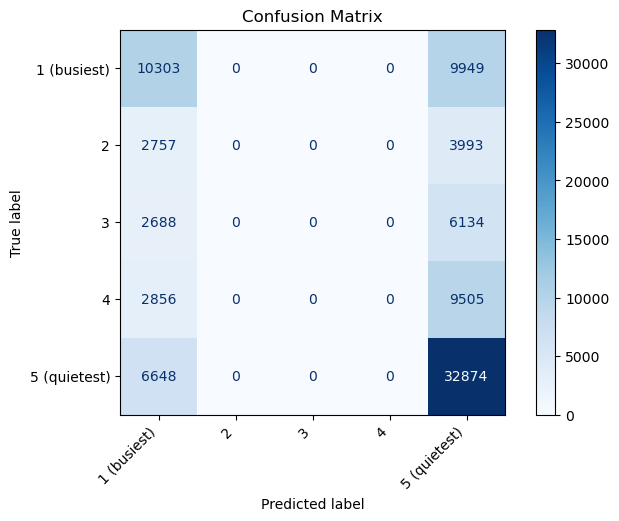


Classification Report:
              precision    recall  f1-score       support
1              0.408007  0.508740  0.452839  20252.000000
2              0.000000  0.000000  0.000000   6750.000000
3              0.000000  0.000000  0.000000   8822.000000
4              0.000000  0.000000  0.000000  12361.000000
5              0.526363  0.831790  0.644734  39522.000000
accuracy       0.492287  0.492287  0.492287      0.492287
macro avg      0.186874  0.268106  0.219515  87707.000000
weighted avg   0.331398  0.492287  0.395089  87707.000000


/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [81]:
y_pred_logreg = logreg.predict(X_test)

evaluate_model(y_test, y_pred_logreg)

### Balanced Data

In [82]:
logreg.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=5000)

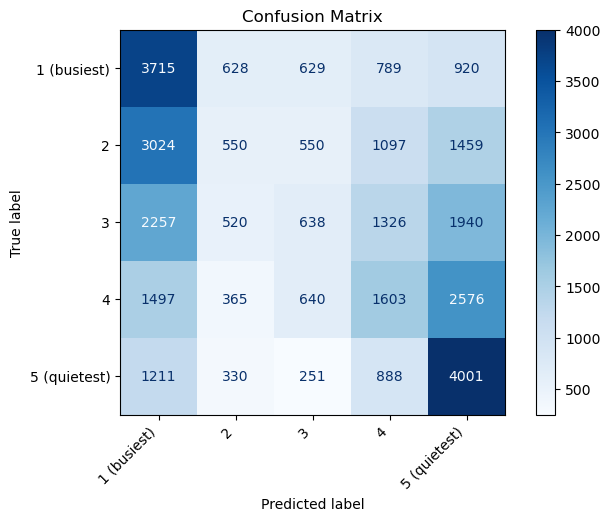


Classification Report:
              precision    recall  f1-score       support
1              0.317413  0.556054  0.404134   6681.000000
2              0.229837  0.082335  0.121239   6680.000000
3              0.235598  0.095495  0.135904   6681.000000
4              0.281080  0.239934  0.258882   6681.000000
5              0.367199  0.598862  0.455254   6681.000000
accuracy       0.314543  0.314543  0.314543      0.314543
macro avg      0.286225  0.314536  0.275083  33404.000000
weighted avg   0.286227  0.314543  0.275087  33404.000000


In [83]:
y_balanced_pred_logreg = logreg.predict(X_test_balanced)

evaluate_model(y_test_balanced, y_balanced_pred_logreg)

### Encoded Data

In [84]:
logreg.fit(X_train_encoded, y_train_encoded)

LogisticRegression(max_iter=5000)

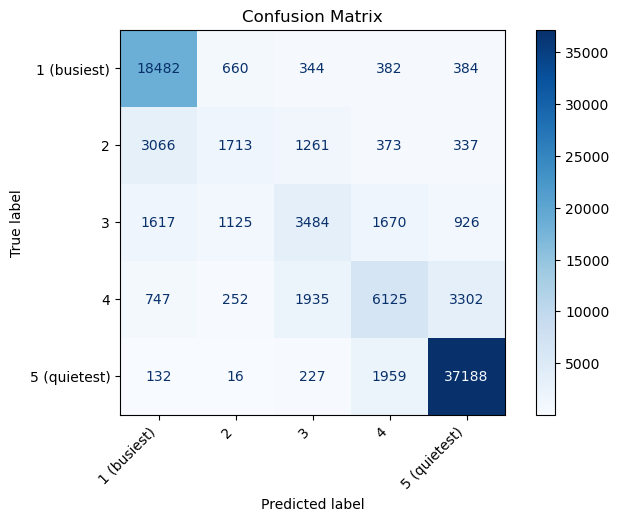


Classification Report:
              precision    recall  f1-score       support
1              0.768674  0.912601  0.834477  20252.000000
2              0.454859  0.253778  0.325789   6750.000000
3              0.480485  0.394922  0.433522   8822.000000
4              0.582834  0.495510  0.535636  12361.000000
5              0.882550  0.940944  0.910812  39522.000000
accuracy       0.763816  0.763816  0.763816      0.763816
macro avg      0.633880  0.599551  0.608047  87707.000000
weighted avg   0.740658  0.763816  0.747278  87707.000000


In [85]:
y_encoded_pred_logreg = logreg.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_logreg)

### Weighted Data

In [86]:
logreg.fit(X_train_weighted, y_train_weighted)

LogisticRegression(max_iter=5000)

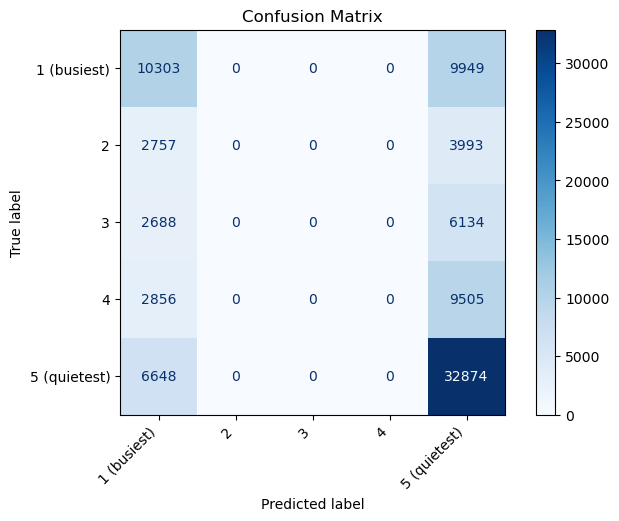


Classification Report:
              precision    recall  f1-score       support
1              0.408007  0.508740  0.452839  20252.000000
2              0.000000  0.000000  0.000000   6750.000000
3              0.000000  0.000000  0.000000   8822.000000
4              0.000000  0.000000  0.000000  12361.000000
5              0.526363  0.831790  0.644734  39522.000000
accuracy       0.492287  0.492287  0.492287      0.492287
macro avg      0.186874  0.268106  0.219515  87707.000000
weighted avg   0.331398  0.492287  0.395089  87707.000000


/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [87]:
y_weighted_pred_logreg = logreg.predict(X_test_weighted)

evaluate_model(y_test_weighted, y_weighted_pred_logreg)

# 2. Ordinal Logistic Regression
### Original Data

In [88]:
ordinal_model = LogisticIT()
ordinal_model.fit(X_train, y_train)

LogisticIT()

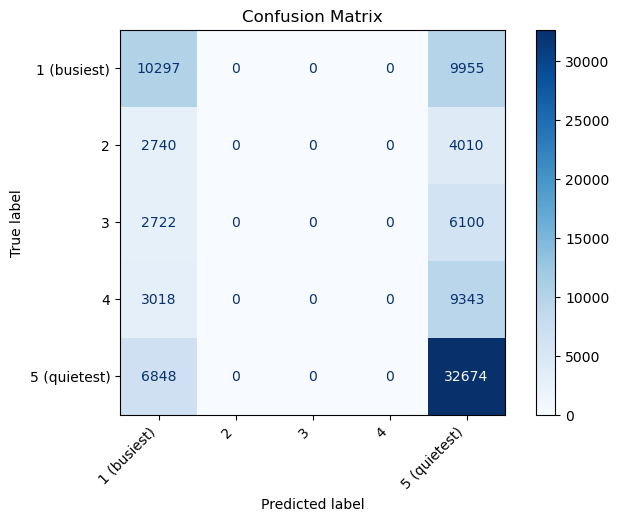


Classification Report:
              precision    recall  f1-score       support
1              0.401834  0.508444  0.448896  20252.000000
2              0.000000  0.000000  0.000000   6750.000000
3              0.000000  0.000000  0.000000   8822.000000
4              0.000000  0.000000  0.000000  12361.000000
5              0.526304  0.826729  0.643164  39522.000000
accuracy       0.489938  0.489938  0.489938      0.489938
macro avg      0.185628  0.267035  0.218412  87707.000000
weighted avg   0.329945  0.489938  0.393471  87707.000000


/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [89]:
y_pred_ordinal = ordinal_model.predict(X_test)

evaluate_model(y_test, y_pred_ordinal)

### Balanced Data

In [90]:
ordinal_model.fit(X_train_balanced, y_train_balanced)

LogisticIT()

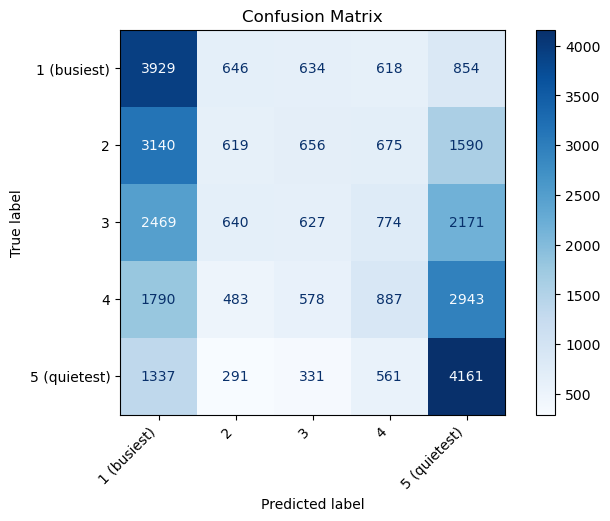


Classification Report:
              precision    recall  f1-score       support
1              0.310225  0.588086  0.406182   6681.000000
2              0.231056  0.092665  0.132279   6680.000000
3              0.221868  0.093848  0.131903   6681.000000
4              0.252347  0.132765  0.173990   6681.000000
5              0.355064  0.622811  0.452283   6681.000000
accuracy       0.306041  0.306041  0.306041      0.306041
macro avg      0.274112  0.306035  0.259327  33404.000000
weighted avg   0.274114  0.306041  0.259331  33404.000000


In [91]:
y_balanced_pred_ordinal = ordinal_model.predict(X_test_balanced)

evaluate_model(y_test_balanced, y_balanced_pred_ordinal)

### Encoded Data

In [92]:
ordinal_model.fit(X_train_encoded, y_train_encoded)

LogisticIT()

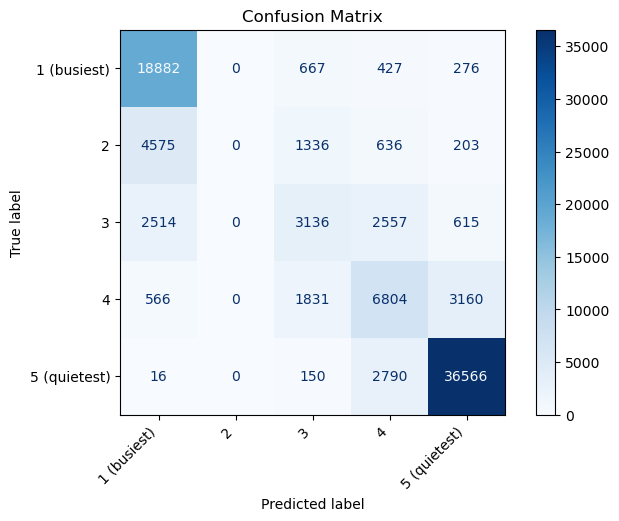


Classification Report:
              precision    recall  f1-score       support
1              0.711106  0.932352  0.806837  20252.000000
2              0.000000  0.000000  0.000000   6750.000000
3              0.440449  0.355475  0.393426   8822.000000
4              0.514908  0.550441  0.532082  12361.000000
5              0.895786  0.925206  0.910259  39522.000000
accuracy       0.745528  0.745528  0.745528      0.745528
macro avg      0.512450  0.552695  0.528521  87707.000000
weighted avg   0.684723  0.745528  0.711040  87707.000000


/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dillonhennessy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [93]:
y_encoded_pred_ordinal = ordinal_model.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_ordinal)

# 3. Random Forest
### Original Data

In [94]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [95]:
y_pred_rf = rf.predict(X_test)

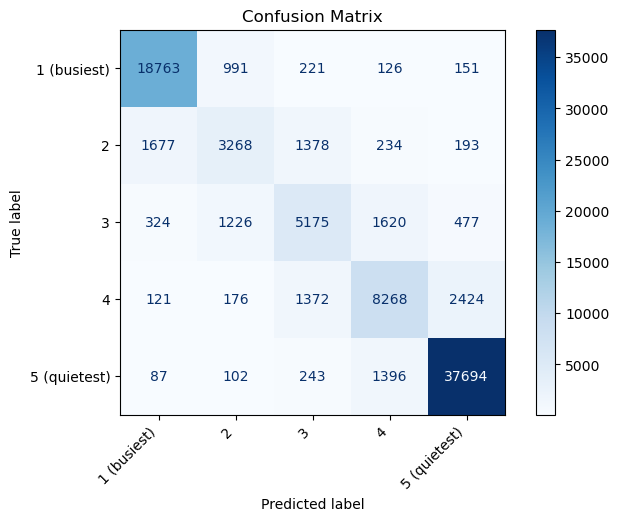


Classification Report:
              precision    recall  f1-score       support
1              0.894669  0.926476  0.910295  20252.000000
2              0.567066  0.484148  0.522337   6750.000000
3              0.616879  0.586602  0.601360   8822.000000
4              0.710065  0.668878  0.688856  12361.000000
5              0.920736  0.953747  0.936951  39522.000000
accuracy       0.834232  0.834232  0.834232      0.834232
macro avg      0.741883  0.723970  0.731960  87707.000000
weighted avg   0.827244  0.834232  0.830166  87707.000000


In [96]:
evaluate_model(y_test, y_pred_rf)

### Balanced Data

In [97]:
rf.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(random_state=42)

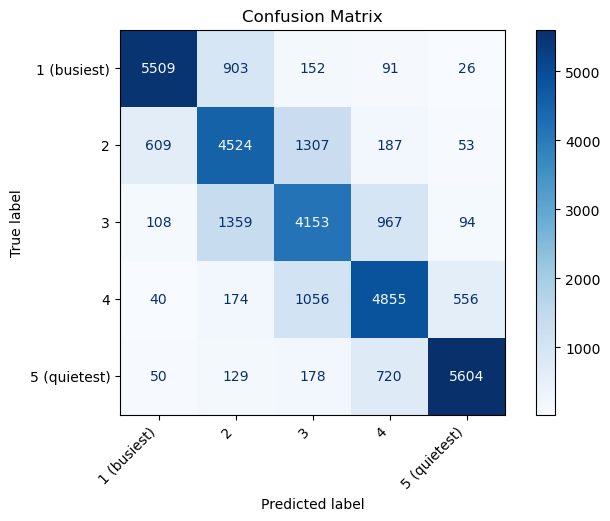


Classification Report:
              precision    recall  f1-score       support
1              0.872229  0.824577  0.847734   6681.000000
2              0.638172  0.677246  0.657128   6680.000000
3              0.606632  0.621614  0.614031   6681.000000
4              0.711877  0.726688  0.719206   6681.000000
5              0.884889  0.838797  0.861226   6681.000000
accuracy       0.737786  0.737786  0.737786      0.737786
macro avg      0.742760  0.737784  0.739865  33404.000000
weighted avg   0.742763  0.737786  0.739868  33404.000000


In [98]:
y_balanced_pred_rf = rf.predict(X_test_balanced)
evaluate_model(y_test_balanced, y_balanced_pred_rf)

### Encoded Data

In [99]:
rf.fit(X_train_encoded, y_train_encoded)

RandomForestClassifier(random_state=42)

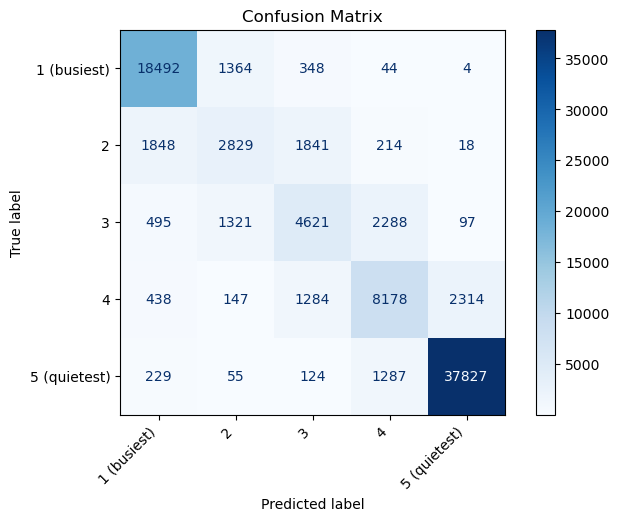


Classification Report:
              precision    recall  f1-score       support
1              0.860013  0.913095  0.885759  20252.000000
2              0.494927  0.419111  0.453875   6750.000000
3              0.562302  0.523804  0.542371   8822.000000
4              0.680876  0.661597  0.671098  12361.000000
5              0.939568  0.957112  0.948259  39522.000000
accuracy       0.820311  0.820311  0.820311      0.820311
macro avg      0.707537  0.694944  0.700272  87707.000000
weighted avg   0.812572  0.820311  0.815891  87707.000000


In [100]:
y_encoded_pred_rf = rf.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_rf)

### Weighted Data

In [101]:
rf.fit(X_train_weighted, y_train_weighted)

RandomForestClassifier(random_state=42)

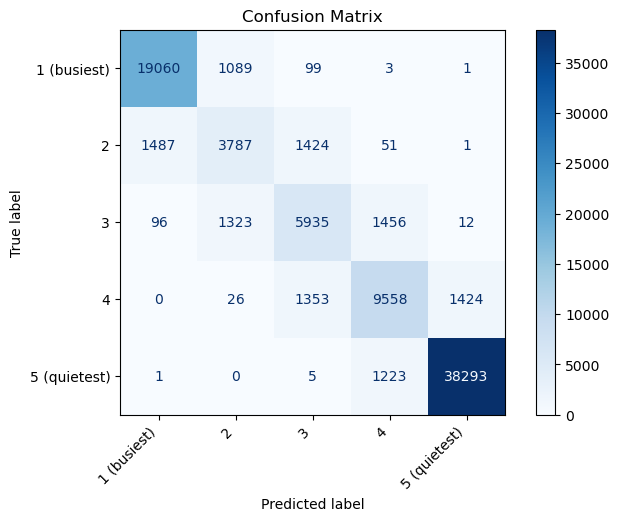


Classification Report:
              precision    recall  f1-score       support
1              0.923271  0.941142  0.932121  20252.000000
2              0.608353  0.561037  0.583738   6750.000000
3              0.673208  0.672750  0.672979   8822.000000
4              0.777642  0.773238  0.775434  12361.000000
5              0.963807  0.968903  0.966348  39522.000000
accuracy       0.873739  0.873739  0.873739      0.873739
macro avg      0.789256  0.783414  0.786124  87707.000000
weighted avg   0.871624  0.873739  0.872584  87707.000000


In [102]:
y_weighted_pred_rf = rf.predict(X_test_weighted)

evaluate_model(y_test_weighted, y_weighted_pred_rf)

# XGBoost
### Original Data  
**Must be adjusted to represent [0, 1, 2, 3, 4]**

In [103]:
y_adjusted = y - 1
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

In [104]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, enable_categorical=True)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

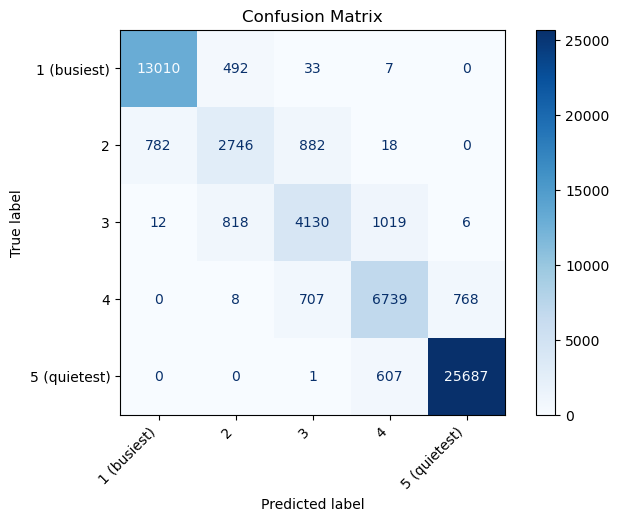


Classification Report:
              precision    recall  f1-score      support
0              0.942480  0.960715  0.951510  13542.00000
1              0.675689  0.620145  0.646726   4428.00000
2              0.717886  0.690058  0.703697   5985.00000
3              0.803218  0.819630  0.811341   8222.00000
4              0.970749  0.976878  0.973804  26295.00000
accuracy       0.894650  0.894650  0.894650      0.89465
macro avg      0.822005  0.813485  0.817416  58472.00000
weighted avg   0.892418  0.894650  0.893380  58472.00000


In [105]:
y_pred_xgb = xgb.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_xgb)

### Weighted Data

In [106]:
y_weighted_adjusted = y_weighted - 1

X_train_weighted_adjusted, X_test_weighted_adjusted, y_train_weighted_adjusted, y_test_weighted_adjusted = train_test_split(X_weighted, y_weighted_adjusted, test_size=0.3, random_state=42)

In [107]:
xgb.fit(X_train_weighted_adjusted, y_train_weighted_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

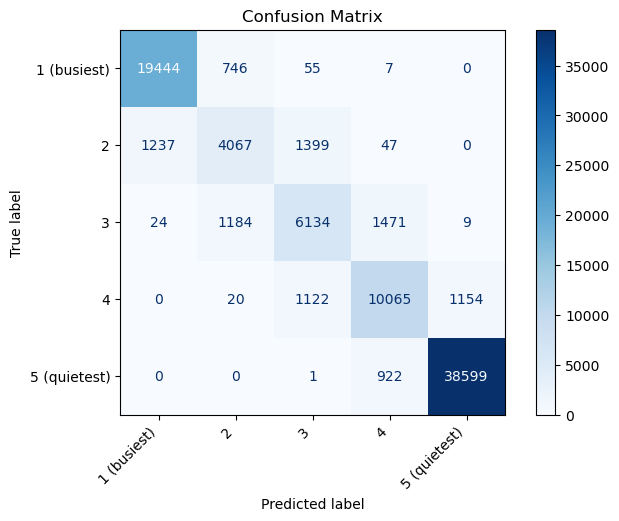


Classification Report:
              precision    recall  f1-score       support
0              0.939097  0.960103  0.949484  20252.000000
1              0.675918  0.602519  0.637111   6750.000000
2              0.704167  0.695307  0.699709   8822.000000
3              0.804428  0.814255  0.809311  12361.000000
4              0.970751  0.976646  0.973690  39522.000000
accuracy       0.892848  0.892848  0.892848      0.892848
macro avg      0.818872  0.809766  0.813861  87707.000000
weighted avg   0.890496  0.892848  0.891472  87707.000000


In [108]:
y_pred_weighted_xgb = xgb.predict(X_test_weighted_adjusted)

evaluate_model(y_test_weighted_adjusted, y_pred_weighted_xgb)

# Ensemble (rf, xgboost)

In [109]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
ensemble.fit(X_train_adjusted, y_train_adjusted)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

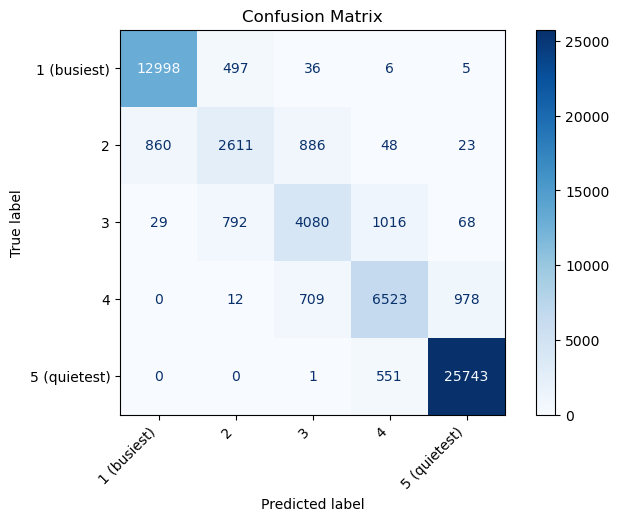


Classification Report:
              precision    recall  f1-score       support
0              0.935983  0.959829  0.947756  13542.000000
1              0.667434  0.589657  0.626139   4428.000000
2              0.714286  0.681704  0.697615   5985.000000
3              0.800958  0.793359  0.797140   8222.000000
4              0.959951  0.979007  0.969385  26295.000000
accuracy       0.888545  0.888545  0.888545      0.888545
macro avg      0.815722  0.800711  0.807607  58472.000000
weighted avg   0.884746  0.888545  0.886345  58472.000000


In [110]:
y_pred_ensemble = ensemble.predict(X_test_adjusted)
evaluate_model(y_test_adjusted, y_pred_ensemble)

# Stacking

In [111]:
base_models = [
    ('rf', rf),
    ('xgb', xgb)
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking.fit(X_train_adjusted, y_train_adjusted)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression())

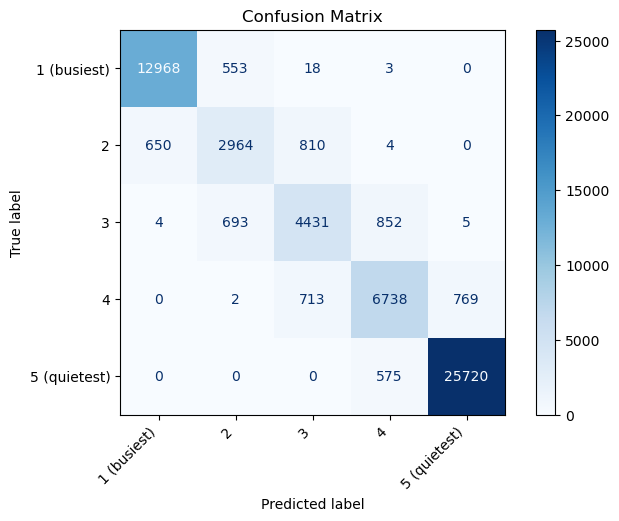


Classification Report:
              precision    recall  f1-score       support
0              0.951989  0.957613  0.954793  13542.000000
1              0.703704  0.669377  0.686111   4428.000000
2              0.741962  0.740351  0.741156   5985.000000
3              0.824523  0.819509  0.822008   8222.000000
4              0.970786  0.978133  0.974445  26295.000000
accuracy       0.903355  0.903355  0.903355      0.903355
macro avg      0.838593  0.832996  0.835703  58472.000000
weighted avg   0.902219  0.903355  0.902745  58472.000000


In [112]:
y_pred_stacking = stacking.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_stacking)

In [113]:
with open('taxi_stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking, file)

In [114]:
with open('taxi_stacking_model.pkl', 'rb') as file:
    stacking_model = pickle.load(file)

# Check if the object is a pandas DataFrame
if isinstance(stacking_model, pd.DataFrame):
    # Print DataFrame information and first few rows
    print(stacking_model.info())
    print(stacking_model.head())
else:
    print(stacking_model)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                         